# 데이터 전처리 방안 수정
- `04_09_FE_.ipynb`의 내용을 기본적으로 유지
- `transaction_cnt` 복구
- `item_name` + `item_category_name` 에 대해 TF-IDF를 적용하여 피처를 추가
- `item_cnt_month_lag_12`, `date_item_avg_price_lag_12` 피처 추가 + 초기 11개월 데이터 제거

# Module

In [1]:
import calendar
import re
from itertools import product
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

%matplotlib inline
plt.style.use("seaborn-v0_8-white")

# Data

In [2]:
data_path = "./data/"

sales_train = pd.read_csv(data_path + 'sales_train.csv')
items = pd.read_csv(data_path + 'items.csv')
item_categories = pd.read_csv(data_path + 'item_categories.csv')
shops = pd.read_csv(data_path + 'shops.csv')

test = pd.read_csv(data_path + 'test.csv')
sub = pd.read_csv(data_path + 'sample_submission.csv')

print('Before Filter ShopID:', len(sales_train))
unique_test_shop_id = test['shop_id'].unique()
sales_train = sales_train[sales_train['shop_id'].isin(unique_test_shop_id)]
print('After Filter ShopID :', len(sales_train))

Before Filter ShopID: 2935849
After Filter ShopID : 2413246


In [3]:
def downcast(df, verbose=True):
    start_memory = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col]%1==0).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        elif dtype_name.startswith('float'):
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_memory = df.memory_usage().sum() / 1024**2
    
    if verbose:
        print(f"Memory usage reduced from {start_memory:.2f} MB to {end_memory:.2f} MB")
        
    return df


data_files = [sales_train, items, shops, item_categories, test]
for file in data_files:
    file = downcast(file)

Memory usage reduced from 128.88 MB to 69.04 MB
Memory usage reduced from 0.51 MB to 0.23 MB
Memory usage reduced from 0.00 MB to 0.00 MB
Memory usage reduced from 0.00 MB to 0.00 MB
Memory usage reduced from 4.90 MB to 1.43 MB


In [4]:
train = []

for i in sales_train['date_block_num'].unique():
    all_shop = sales_train.loc[sales_train['date_block_num'] == i, 'shop_id'].unique()
    all_item = sales_train.loc[sales_train['date_block_num'] == i, 'item_id'].unique()
    train.append(np.array(list(product([i], all_shop, all_item))))

# idx features        
idx_features = ['date_block_num', 'shop_id', 'item_id']
train = pd.DataFrame(np.vstack(train), columns=idx_features)

test['date_block_num'] = 34
train.head()

,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2552
2,0,59,2554
3,0,59,2555
4,0,59,2564


# Feature Engineering

## Outliers
- `-1` 같은 음수값은 반품을 의미할 수 있음. 제거하지 않고 `item_cnt_month`로 집계

In [5]:
print("Before : ",len(sales_train))
sales_train = sales_train[sales_train['item_cnt_day'] < 1000]
print("After item_cnt_day : ",len(sales_train))
sales_train = sales_train[sales_train['item_price'] < 50000]
print("After item_price : ",len(sales_train))

Before :  2413246
After item_cnt_day :  2413244
After item_price :  2413241


## Feature Generation

In [6]:
def add_mean_features(df: pd.DataFrame, groupby_features: list, mean_feature_list: list = None):
    col_name = [col for col in groupby_features if col != 'date_block_num']
    base_name = '_'.join([col.replace('_id', '') for col in col_name])
    feature_name = f'{base_name}_avg_date_sales'
    
    agg_rules = {
        feature_name: ('item_cnt_month', 'mean')
    }
            
    group = df.groupby(groupby_features).agg(**agg_rules).reset_index()
    
    df = df.merge(group, on=groupby_features, how='left')
    df = downcast(df, verbose=False)
    del group
    
    if mean_feature_list is not None:
        mean_feature_list.append(feature_name)
    
    return df

def add_lag_features(df: pd.DataFrame, key_features: list, lag_features_info: dict, lag_period: list):
    """
    lag_features_info: {'feature_name_1': clip_flag_1, 'feature_name_2': clip_flag_2, ...}
    """
    
    group_keys = [key for key in key_features if key != 'date_block_num']
    grouped = df.groupby(group_keys)
    
    all_lag_cols = []
    features_to_clip = []

    for lag_feature, clip_flag in lag_features_info.items():
        for i in lag_period:
            lag_feature_name = f'{lag_feature}_lag_{i}'
            df[lag_feature_name] = grouped[lag_feature].shift(i).fillna(0)
            
            all_lag_cols.append(lag_feature_name)
            if clip_flag:
                features_to_clip.append(lag_feature_name)
    
    return df, features_to_clip

### shops

In [7]:
# 데이터 수정
sales_train.loc[sales_train['shop_id']==0, 'shop_id'] = 57
sales_train.loc[sales_train['shop_id']==1, 'shop_id'] = 58
sales_train.loc[sales_train['shop_id']==10, 'shop_id'] = 11
sales_train.loc[sales_train['shop_id']==39, 'shop_id'] = 40

test.loc[test['shop_id']==0, 'shop_id'] = 57
test.loc[test['shop_id']==1, 'shop_id'] = 58
test.loc[test['shop_id']==10, 'shop_id'] = 11
test.loc[test['shop_id']==39, 'shop_id'] = 40

# 도시 구분
shops['city'] = shops['shop_name'].str.split(' ').str[0]
shops.loc[shops['city'] == '!Якутск', 'city'] = 'Якутск'

# 쇼핑몰/센터를 나타내는 러시아어 약어로 상점 구분
mall_keywords = ['ТЦ', 'ТРК', 'ТРЦ', 'MALL', 'Молл']
is_mall = shops['shop_name'].apply(lambda x: any(keyword in x for keyword in mall_keywords))

shops['shop_type'] = np.where(is_mall, 'Mall', 'Standalone')

encoder = LabelEncoder()
for col in ['city', 'shop_type']:
    shops[col] = encoder.fit_transform(shops[col])

shops = shops.drop(columns=["shop_name"])

### items

In [8]:
items['first_sale_month'] = sales_train.groupby('item_id').agg({'date_block_num': 'min'})['date_block_num']
items = items.fillna(34)

##### 아이템별 평균가격

In [9]:
# 아이템별 평균 가격
group = sales_train.groupby(['item_id']).agg(item_avg_price=('item_price', 'mean')).reset_index()
items = items.merge(group, on='item_id', how='left')

temp = sales_train.merge(items[['item_id', 'item_category_id']], on='item_id', how='left')
cat_price_map = temp.groupby('item_category_id')['item_price'].mean()
items['item_avg_price'] = items['item_avg_price'].fillna(items['item_category_id'].map(cat_price_map))
item_avg_price = items[['item_id', 'item_avg_price']]

del temp, cat_price_map, items['item_avg_price']

##### 월별 아이템 평균가격

In [10]:
date_item_avg_price = sales_train.groupby(['date_block_num', 'item_id']).agg(date_item_avg_price=('item_price', 'mean')).reset_index()

### TF-IDF

In [11]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

items = items.merge(item_categories, on='item_category_id', how='left')
items['item_full_name'] = items['item_category_name'] + ' ' + items['item_name']
items['clean_item_name'] = items['item_full_name'].apply(clean_text)

tfidf = TfidfVectorizer(max_features=1000)
item_name_tfidf = tfidf.fit_transform(items['clean_item_name'])

svd = TruncatedSVD(n_components=50, random_state=2025)
item_name_svd = svd.fit_transform(item_name_tfidf.toarray())

pca_cols = [f'item_name_svd_{i}' for i in range(50)]
item_name_svd_df = pd.DataFrame(item_name_svd, columns=pca_cols)
item_name_svd_df['item_id'] = items['item_id']

items = items.merge(item_name_svd_df, on='item_id', how='left')
items.head()

,item_name,item_id,item_category_id,first_sale_month,item_category_name,item_full_name,clean_item_name,item_name_svd_0,item_name_svd_1,item_name_svd_2,...,item_name_svd_40,item_name_svd_41,item_name_svd_42,item_name_svd_43,item_name_svd_44,item_name_svd_45,item_name_svd_46,item_name_svd_47,item_name_svd_48,item_name_svd_49
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,34.0,Кино - DVD,Кино - DVD ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) ...,кино dvd во власти наваждения пласт d,0.343956,-0.072842,-0.003275,...,-0.001050,0.000110,-0.000051,0.004225,0.001599,-0.003587,0.002660,-0.001272,0.002163,0.000093
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,15.0,Программы - Для дома и офиса (Цифра),Программы - Для дома и офиса (Цифра) !ABBYY Fi...,программы для дома и офиса цифра abbyy finere...,0.004050,0.000853,0.029947,...,0.008045,-0.006353,-0.011449,0.006689,0.036530,0.023058,-0.027416,-0.025397,0.119810,0.006392
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,34.0,Кино - DVD,Кино - DVD ***В ЛУЧАХ СЛАВЫ (UNV) ...,кино dvd в лучах славы unv ...,0.927008,-0.195910,-0.009256,...,0.000645,0.001268,-0.008036,0.003646,0.000094,-0.008105,0.002925,-0.003326,0.001037,-0.000136
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,34.0,Кино - DVD,Кино - DVD ***ГОЛУБАЯ ВОЛНА (Univ) ...,кино dvd голубая волна univ ...,0.927008,-0.195910,-0.009256,...,0.000645,0.001268,-0.008036,0.003646,0.000094,-0.008105,0.002925,-0.003326,0.001037,-0.000136
4,***КОРОБКА (СТЕКЛО) D,4,40,34.0,Кино - DVD,Кино - DVD ***КОРОБКА (СТЕКЛО) ...,кино dvd коробка стекло d,0.355035,-0.075058,-0.003462,...,0.000006,0.000102,-0.004619,0.001355,0.004287,-0.002326,-0.000063,-0.001348,-0.002157,-0.004297


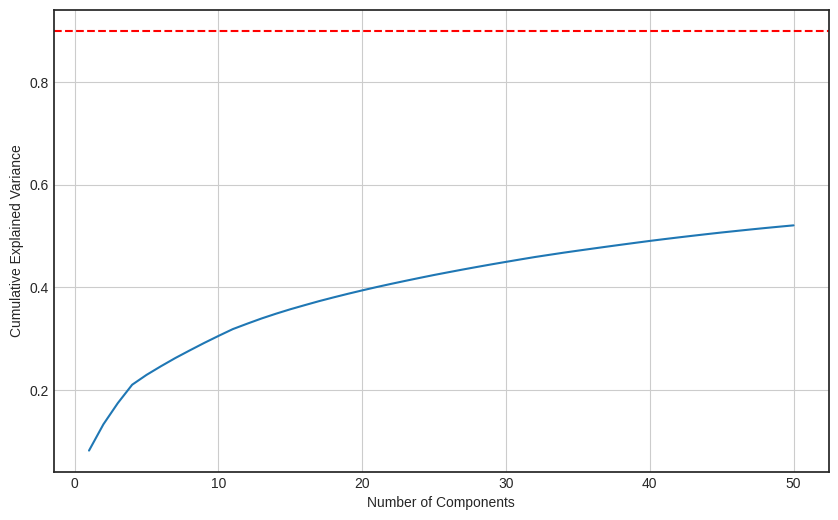

원본 데이터의 90%를 설명하기 위한 차원 수: 1


In [12]:
cumsum = np.cumsum(svd.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, len(cumsum) + 1), y=cumsum)
plt.grid(True)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.9, color='r', linestyle='--')
plt.show()

d = np.argmax(cumsum >= 0.9) + 1
print(f"원본 데이터의 90%를 설명하기 위한 차원 수: {d}")

In [13]:
items = items.drop(columns=['clean_item_name', 'item_name', 'item_full_name', 'item_category_name'])

### item_categories

In [14]:
def split_categories(df):
    def split_func(name):
        if '-' in name:
            return name.split('-', 1)
        else:
            return [name, name]
    
    split_result = df['item_category_name'].apply(lambda x: split_func(x))
    df['type'] = split_result.apply(lambda x: x[0].strip())
    df['subtype'] = split_result.apply(lambda x: x[1].strip())
    return df


item_categories = split_categories(item_categories)
etc_types = item_categories['type'].value_counts()[item_categories['type'].value_counts()<5].index.tolist()
item_categories.loc[item_categories['type'].isin(etc_types), 'type'] = 'etc'
item_categories['type'] = LabelEncoder().fit_transform(item_categories['type'])
item_categories['subtype'] = LabelEncoder().fit_transform(item_categories['subtype'])
item_categories = item_categories.drop('item_category_name', axis=1)

### revenue

In [15]:
sales_train['revenue'] = sales_train['item_cnt_day'] * sales_train['item_price']
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,02.01.2013,0,59,22154,999.00,1,999.00
1,03.01.2013,0,25,2552,899.00,1,899.00
2,05.01.2013,0,25,2552,899.00,-1,-899.00
3,06.01.2013,0,25,2554,1709.05,1,1709.05
4,15.01.2013,0,25,2555,1099.00,1,1099.00


### set up matrix

In [16]:
group = sales_train.groupby(idx_features).agg(
    item_cnt_month = ('item_cnt_day', 'sum'),
    transaction_cnt = ('item_cnt_day', 'count'),
    date_revenue = ('revenue', 'sum')
).reset_index()

train = train.merge(group, on=idx_features, how='left')
all_data = pd.concat([train, test.drop('ID', axis=1)], ignore_index=True, keys=idx_features)
all_data = all_data.merge(shops, on='shop_id', how='left')
all_data = all_data.merge(items, on='item_id', how='left')
all_data = all_data.merge(item_avg_price, on='item_id', how='left')
all_data = all_data.merge(date_item_avg_price, on=['date_block_num', 'item_id'], how='left')
all_data = all_data.merge(item_categories, on='item_category_id', how='left')
all_data.head()

/tmp/ipykernel_11985/1022461244.py:8: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences
  all_data = pd.concat([train, test.drop('ID', axis=1)], ignore_index=True, keys=idx_features)


,date_block_num,shop_id,item_id,item_cnt_month,transaction_cnt,date_revenue,city,shop_type,item_category_id,first_sale_month,...,item_name_svd_44,item_name_svd_45,item_name_svd_46,item_name_svd_47,item_name_svd_48,item_name_svd_49,item_avg_price,date_item_avg_price,type,subtype
0,0,59,22154,1.0,1.0,999.0,30,0,37,0.0,...,-0.021204,-0.004256,0.016794,-0.028321,-0.014512,0.007924,678.166667,999.00,4,1
1,0,59,2552,NaN,NaN,NaN,30,0,58,0.0,...,-0.022861,0.004538,0.004234,-0.018647,0.009573,0.021213,936.500000,899.00,6,29
2,0,59,2554,NaN,NaN,NaN,30,0,58,0.0,...,-0.017468,0.012725,0.005498,-0.016085,0.031886,0.016630,1709.050000,1709.05,6,29
3,0,59,2555,NaN,NaN,NaN,30,0,56,0.0,...,-0.108118,0.039646,0.050580,-0.073855,0.023172,0.020620,1122.076923,1099.00,6,5
4,0,59,2564,NaN,NaN,NaN,30,0,59,0.0,...,-0.022955,0.034200,0.015894,-0.011793,0.087889,-0.009264,341.307692,349.00,6,42


In [17]:
all_data.isna().sum()

date_block_num               0
shop_id                      0
item_id                      0
item_cnt_month         7513150
transaction_cnt        7513150
                        ...   
item_name_svd_49             0
item_avg_price               0
date_item_avg_price     214277
type                         0
subtype                      0
Length: 64, dtype: int64

> 결측치 처리 방향

- `item_cnt_month`, `transaction_cnt`, `date_revenue`는 판매가 없어 nan으로 표시된 걸로 추정 -> 결측치를 0으로 대체
- `date_item_avg_price` 는 월별 아이템카테고리 평균가격으로 대체

In [18]:
fill_zero_cols = ['item_cnt_month', 'transaction_cnt', 'date_revenue']
all_data[fill_zero_cols] = all_data[fill_zero_cols].fillna(0)

cat_date_price = all_data.groupby(['date_block_num', 'item_category_id'])['date_item_avg_price'].mean().reset_index()
cat_date_price.columns = ['date_block_num', 'item_category_id', 'date_cat_avg_price']
all_data = all_data.merge(cat_date_price, on=['date_block_num', 'item_category_id'], how='left')
all_data['date_item_avg_price'] = all_data['date_item_avg_price'].fillna(all_data['date_cat_avg_price'])

all_data = all_data.drop(columns=['date_cat_avg_price'])

In [19]:
need_lag_list = []
features_to_drop = []

need_lag_list.extend(['item_cnt_month', 'transaction_cnt', 'date_item_avg_price'])
features_to_drop.append('date_revenue')

In [20]:
del shops, items, item_categories, group, cat_date_price 
all_data = downcast(all_data)

Memory usage reduced from 4143.18 MB to 1991.75 MB


### mean features

In [21]:
all_data = add_mean_features(all_data, ['date_block_num', 'shop_id'])
all_data = add_mean_features(all_data, ['date_block_num', 'shop_id', 'item_category_id'])

all_data = add_mean_features(all_data, ['date_block_num', 'item_id'])

all_data = add_mean_features(all_data, ['date_block_num', 'item_category_id'])
all_data = add_mean_features(all_data, ['date_block_num', 'subtype'])

In [22]:
mean_feature_list = [col for col in all_data.columns if '_avg_date_sales' in col]
mean_feature_list

['shop_avg_date_sales',
 'shop_item_category_avg_date_sales',
 'item_avg_date_sales',
 'item_category_avg_date_sales',
 'subtype_avg_date_sales']

In [23]:
need_lag_list.extend(mean_feature_list)

### lag features

In [24]:
need_lag_list

['item_cnt_month',
 'transaction_cnt',
 'date_item_avg_price',
 'shop_avg_date_sales',
 'shop_item_category_avg_date_sales',
 'item_avg_date_sales',
 'item_category_avg_date_sales',
 'subtype_avg_date_sales']

In [25]:
%%time
lag_period = [1, 2, 3]
clip_list = []
lag_features_to_process = {}

lag_features_to_process['item_cnt_month'] = True
for lag_feature in need_lag_list:
    if lag_feature == 'item_cnt_month':
        continue
    lag_features_to_process[lag_feature] = False

all_data, clip_list = add_lag_features(all_data, 
                                        key_features=idx_features,
                                        lag_features_info=lag_features_to_process,
                                        lag_period=lag_period)

all_data = downcast(all_data)

features_to_drop.extend(need_lag_list)
features_to_drop.remove('item_cnt_month')

Memory usage reduced from 3269.16 MB to 2941.40 MB
CPU times: user 11.4 s, sys: 3.08 s, total: 14.5 s
Wall time: 16.2 s


In [26]:
all_data = all_data.copy()

### trend features - price, revenue

In [27]:
new_columns = {}
cols_delta_price = []

for i in lag_period:
    col_name = f'delta_price_lag_{i}'
    new_columns[col_name] = (all_data[f'date_item_avg_price_lag_{i}'] - all_data['item_avg_price']) / all_data['item_avg_price']
    cols_delta_price.append(col_name)

new_cols_df = pd.DataFrame(new_columns)
all_data = pd.concat([all_data, new_cols_df], axis=1)
filled_series = all_data[cols_delta_price].bfill(axis=1).iloc[:, 0]
all_data['delta_price_lag'] = filled_series.fillna(0)

features_to_drop.extend(cols_delta_price)
features_to_drop.append('item_avg_price')
all_data = downcast(all_data)

Memory usage reduced from 3210.33 MB to 3075.87 MB


In [28]:
# add shop_date_avg_revenue
shop_date_rev = all_data.groupby(['date_block_num', 'shop_id'])['date_revenue'].mean().reset_index()
shop_date_rev.columns = ['date_block_num', 'shop_id', 'shop_date_avg_revenue']

all_data = all_data.merge(shop_date_rev, on=['date_block_num', 'shop_id'], how='left')
features_to_drop.append('shop_date_avg_revenue')

# add shop_avg_revenue
shop_avg_revenue = all_data.groupby('shop_id')['shop_date_avg_revenue'].mean().reset_index()
shop_avg_revenue.columns = ['shop_id', 'shop_revenue_mean']
all_data = all_data.merge(shop_avg_revenue, on='shop_id', how='left')

features_to_drop.append('shop_revenue_mean')
del shop_date_rev, shop_avg_revenue

# add lag features for shop_date_avg_revenue
lag_features_to_process = {'shop_date_avg_revenue': False}
all_data, clip_list = add_lag_features(all_data, 
                                        key_features=idx_features,
                                        lag_features_info=lag_features_to_process,
                                        lag_period=lag_period)

all_data = downcast(all_data)

Memory usage reduced from 3412.03 MB to 3243.95 MB


In [29]:
# delta revenue
new_columns = {}
cols_delta_revenue = []

for i in lag_period:
    col_name = f'delta_shop_revenue_lag_{i}'
    new_columns[col_name] = (all_data[f'shop_date_avg_revenue_lag_{i}'] - all_data['shop_revenue_mean']) / all_data['shop_revenue_mean']
    cols_delta_revenue.append(col_name)

new_cols_df = pd.DataFrame(new_columns)
all_data = pd.concat([all_data, new_cols_df], axis=1)
filled_series = all_data[cols_delta_revenue].bfill(axis=1).iloc[:, 0]
all_data['delta_shop_revenue_lag'] = filled_series.fillna(0)

del new_cols_df, new_columns, filled_series
features_to_drop.extend(cols_delta_revenue)
features_to_drop.append('shop_revenue_mean')
all_data = downcast(all_data)
features_to_drop

Memory usage reduced from 3378.41 MB to 3378.41 MB


['date_revenue',
 'transaction_cnt',
 'date_item_avg_price',
 'shop_avg_date_sales',
 'shop_item_category_avg_date_sales',
 'item_avg_date_sales',
 'item_category_avg_date_sales',
 'subtype_avg_date_sales',
 'delta_price_lag_1',
 'delta_price_lag_2',
 'delta_price_lag_3',
 'item_avg_price',
 'shop_date_avg_revenue',
 'shop_revenue_mean',
 'delta_shop_revenue_lag_1',
 'delta_shop_revenue_lag_2',
 'delta_shop_revenue_lag_3',
 'shop_revenue_mean']

### new item

In [30]:
all_data['new_item'] = all_data['first_sale_month'] == all_data['date_block_num']
all_data['item_age'] = all_data['date_block_num'] - all_data['first_sale_month']
features_to_drop.append('first_sale_month')

/tmp/ipykernel_11985/2621700371.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data['new_item'] = all_data['first_sale_month'] == all_data['date_block_num']
/tmp/ipykernel_11985/2621700371.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data['item_age'] = all_data['date_block_num'] - all_data['first_sale_month']


### since last sale date

In [31]:
all_data['temp_last_sale'] = np.nan
all_data.loc[all_data['item_cnt_month']>0, 'temp_last_sale'] = all_data['date_block_num']
last_sale_record = all_data.groupby(['item_id', 'shop_id'])['temp_last_sale'].shift(1).ffill()
all_data['since_last_sale'] = (all_data['date_block_num'] - last_sale_record).fillna(-1)
all_data = all_data.drop(columns='temp_last_sale')

/tmp/ipykernel_11985/798593836.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data['temp_last_sale'] = np.nan
/tmp/ipykernel_11985/798593836.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data['since_last_sale'] = (all_data['date_block_num'] - last_sale_record).fillna(-1)


### days & month

In [32]:
all_data['month'] = all_data['date_block_num'] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
all_data['days'] = all_data['month'].map(days)

/tmp/ipykernel_11985/1583693569.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data['month'] = all_data['date_block_num'] % 12
/tmp/ipykernel_11985/1583693569.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data['days'] = all_data['month'].map(days)


In [33]:
all_data.groupby('month')['item_cnt_month'].mean().reset_index()

,month,item_cnt_month
0,0,0.361002
1,1,0.334841
2,2,0.350510
3,3,0.305403
4,4,0.301577
5,5,0.314516
6,6,0.294632
7,7,0.335717
8,8,0.357936
9,9,0.323847


- 12월의 평균 판매량이 특히 높게 나타남. 1월도 비교적 높음
- 3월과 9월의 평균 판매량이 상대적으로 높음(신학기 영향 예상)
- 테스트 데이터에 해당하는 11월은 평균 판매량이 1년 중 가장 낮음

In [34]:
# 0: Low (11월 포함), 1: Normal, 2: High, 3: Peak
season_dict = {
    11: 3, # 연말
    0: 2, 2: 2, 8: 2, # 0: 연초 / 2, 8: 신학기 
    7: 2, # 7: 저조한 6대비 판매량 회복. 신학기 준비
    1: 1, 3: 1, 4: 1, 5: 1, 9: 1, # 평범
    6: 0, 10: 0  # 6: 비수기, 휴가철 / 10: pre holiday
}

all_data['season_type'] = all_data['month'].map(season_dict).astype('int8')

/tmp/ipykernel_11985/3821215925.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data['season_type'] = all_data['month'].map(season_dict).astype('int8')


In [35]:
def count_weekends(date_block_num):
    year = 2013 + date_block_num // 12
    month = 1 + date_block_num % 12
    
    _, last_day = calendar.monthrange(year, month)
    dates = pd.date_range(start=f'{year}-{month}-01', end=f'{year}-{month}-{last_day}')
    weekend_count = dates.weekday.isin([5, 6]).sum()
    
    return weekend_count

weekend_map = {i: count_weekends(i) for i in range(35)}
all_data['num_weekends'] = all_data['date_block_num'].map(weekend_map).astype('int8')
print(all_data[['date_block_num', 'month', 'num_weekends']].head())

   date_block_num  month  num_weekends
0               0      0             8
1               0      0             8
2               0      0             8
3               0      0             8
4               0      0             8


/tmp/ipykernel_11985/2349975611.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data['num_weekends'] = all_data['date_block_num'].map(weekend_map).astype('int8')


In [36]:
all_data['num_weekends'].value_counts()

num_weekends
8     4500289
9     2556125
10    1755830
Name: count, dtype: int64

### rolling mean/std & lag_1 and lag_12

In [37]:
# 최근 3개월 평균 판매량 & 표준편차
all_data['rolling_3m_mean_cnt'] = all_data[[col for col in all_data.columns if 'item_cnt_month_' in col]].mean(axis=1)
all_data['rolling_3m_std_cnt'] = all_data[[col for col in all_data.columns if 'item_cnt_month_' in col]].std(axis=1)

# 최근 3개월 월별 아이템 가격 평균 & 표준편차
all_data['rolling_3m_mean_price'] = all_data[[col for col in all_data.columns if 'date_item_avg_price_' in col]].mean(axis=1)
all_data['rolling_3m_std_price'] = all_data[[col for col in all_data.columns if 'date_item_avg_price_' in col]].std(axis=1)

# 12개월 전 판매량/아이템 가격
group = all_data.groupby(['shop_id', 'item_id'])
all_data['item_cnt_month_lag_12'] = group['item_cnt_month'].shift(12)
all_data['date_item_avg_price_lag_12'] = group['date_item_avg_price'].shift(12)

features_to_drop.extend(['item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'date_item_avg_price_lag_2', 'date_item_avg_price_lag_3'])
all_data = downcast(all_data)

/tmp/ipykernel_11985/2875172277.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data['rolling_3m_mean_cnt'] = all_data[[col for col in all_data.columns if 'item_cnt_month_' in col]].mean(axis=1)
/tmp/ipykernel_11985/2875172277.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data['rolling_3m_std_cnt'] = all_data[[col for col in all_data.columns if 'item_cnt_month_' in col]].std(axis=1)
/tmp/ipykernel_11985/2875172277.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `

Memory usage reduced from 3958.29 MB to 3739.78 MB


- 작년 동월 판매량 및 평균 가격에 대해 lag_12는 중요한 특징으로 보임
- 다만, 초기 데이터 11개월에 대해선 결측치가 많아 피처의 질이 떨어질 수 있음
- 따라서 초기 11개월의 데이터를 삭제하기로 함

### removing columns

In [38]:
features_to_drop

['date_revenue',
 'transaction_cnt',
 'date_item_avg_price',
 'shop_avg_date_sales',
 'shop_item_category_avg_date_sales',
 'item_avg_date_sales',
 'item_category_avg_date_sales',
 'subtype_avg_date_sales',
 'delta_price_lag_1',
 'delta_price_lag_2',
 'delta_price_lag_3',
 'item_avg_price',
 'shop_date_avg_revenue',
 'shop_revenue_mean',
 'delta_shop_revenue_lag_1',
 'delta_shop_revenue_lag_2',
 'delta_shop_revenue_lag_3',
 'shop_revenue_mean',
 'first_sale_month',
 'item_cnt_month_lag_2',
 'item_cnt_month_lag_3',
 'date_item_avg_price_lag_2',
 'date_item_avg_price_lag_3']

In [39]:
all_data = all_data.drop(columns=features_to_drop)

features_to_drop = []
features_to_drop.extend([col for col in all_data.columns if '_lag_2' in col or '_lag_3' in col])
all_data = all_data.drop(columns=features_to_drop)

print("Shape after dropping lag features:", all_data.shape)
all_data = downcast(all_data)

Shape after dropping lag features: (8812244, 83)
Memory usage reduced from 2495.99 MB to 2495.99 MB


## drop rows with `date_block_num` < 12

In [40]:
all_data = all_data[all_data['date_block_num']>=12].fillna(0)
print(f"Shape after filtering: {all_data.shape}")
all_data = downcast(all_data)

Shape after filtering: (5459310, 83)
Memory usage reduced from 1587.95 MB to 1577.54 MB


In [41]:
joblib.dump(all_data, data_path + 'all_data2.joblib')

['./data/all_data2.joblib']